# ***This notebook showcases the analysis and development of the Eos30f3 Model Reproducibilty done by malik badmus as part of the task for outreachy 2024 contribution.***

***For the sake of clarity, i will refer to the author's model as DPMN-hERG Model, and the Model implemented on Ersilia Model Hub as eos30f3 model***


In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# search path for modules 
sys.path.append(os.path.abspath("../src"))
DATAPATH = "../data"
SRC= "../src"

#File path
input_file_path = os.path.join(DATAPATH, "Raw", "Cai_TableS3_fixed.csv")
input_file_path_1 = os.path.join(DATAPATH, "Raw", "I_test.csv")
input_file_path_2 = os.path.join(DATAPATH, "Model_Predictions", "quiet.log")


# Reading the CSV file into a pandas DataFrame
Original_data = pd.read_csv(input_file_path, delimiter=',')

## Inspect the Datasets

In [2]:
Original_data.head()

,smiles,X10,X20,X40,X60,X80,X100
0,C=1([C@@H](C(=C(C)NC1C)C(OC)=O)c1cc(ccc1)[N+](...,1,1.0,1.0,1.0,1.0,1.0
1,C1(\c2c(CCc3c1cccc3)cccc2)=C\CCN(C)C,1,1.0,1.0,1.0,1.0,1.0
2,c1(c2c(cccc2)oc1CCCC)C(c1cc(c(OCCN(CC)CC)c(c1)...,1,1.0,1.0,1.0,1.0,1.0
3,[H][C@H]1CC[C@@H](C#N)C1C(=O)C3CN(C(C)c2ccc(C#...,1,1.0,1.0,1.0,1.0,1.0
4,[nH]1ccnc1-c2ccc(cc2)OCCCN3CCCCC3,1,1.0,1.0,1.0,1.0,1.0


***They show the predicted probabilities of the compounds at various levels of potency (10 μM, 20 μM, 40 μM, 60 μM, 80 μM, and 100 μM).***

In [3]:
Original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7889 entries, 0 to 7888
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  7889 non-null   object 
 1   X10     7889 non-null   int64  
 2   X20     6548 non-null   float64
 3   X40     5434 non-null   float64
 4   X60     5161 non-null   float64
 5   X80     4940 non-null   float64
 6   X100    4831 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 431.6+ KB


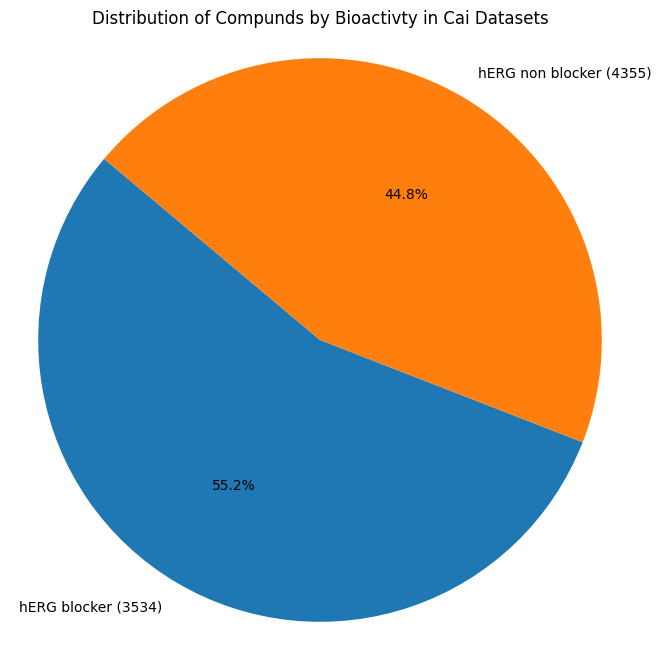

In [4]:
import matplotlib.pyplot as plt

class_counts = Original_data['X10'].value_counts()
class_names = {0: 'hERG non blocker', 1: 'hERG blocker'}

# Create a pie chart
plt.figure(figsize=(8, 8))  
wedges, texts, autotexts = plt.pie(class_counts, labels=class_counts.index.map(class_names), autopct='%1.1f%%', startangle=140)
for i, label in enumerate(texts):
    label.set_text(f"{label.get_text()} ({class_counts[i]})")

plt.title('Distribution of Compunds by Bioactivty in Cai Datasets')  
plt.axis('equal')  
plt.savefig('../figures/cai_datasets_piechart.png')
plt.show()

***This figure above shows the distribution of the Compund bioactive state with IC50 values = 10 μM on the cai dataset, which was used to train the DMPNN-hERG Model, we can observe the number of positive class and negative class and from this we can deduce that the datasets is relatively balanced.***

In [5]:

# I installed the DPMN-hERG model on my sytem according to the author's desription and reproduce the AUC_ROC value from 
# the publications

overall_auc_line = None
with open(input_file_path_2, 'r') as log_file:
    for line in log_file:
        if line.startswith("Overall test auc"):
            overall_auc_line = line.strip()
            break

if overall_auc_line is not None:
    print("Overall test AUC:", overall_auc_line)
else:
    print("Line containing 'Overall test auc' not found in the log file.")

Overall test AUC: Overall test auc = 0.947458 +/- 0.006658


***The above is the exact same AUC-ROC curve value gotten from the publications***

***I observed that the Model that was implemented on Ersilia is different from DMPNN-hERG that was trained with the Datasets above, the Model that was implemented was trained on a datsets of 393 molecules and is available [here](https://github.com/AI-amateur/DMPNN-hERG/blob/main/example_notebook/I_train.csv) and the test datasets is available [here](https://github.com/AI-amateur/DMPNN-hERG/blob/main/example_notebook/I_test.csv.)***

***So i will be running a prediction on both this model and eos30f3 with the test set to reproduce the same exact value/figure.***

***Predictions were run both on DMPNN-hERG Model that was trained on 393 molecules and eos30f3 Model that was implemented on Ersilia with the test data set, the prediction result for both model was saved in data/Model_predictions***

In [6]:

eos30f3_hERG_predictions = pd.read_csv(os.path.join(DATAPATH, "Model_predictions", "eos30f3_predictions.csv"))

DPMN_preds = pd.read_csv(os.path.join(DATAPATH, "Model_predictions", "DPMN_preds.csv"))

test_data = pd.read_csv(input_file_path_1, delimiter=',')

## Calculating the AUC score and plotting the ROC curve for eos30f3 model 

AUC = 0.793 ± 0.036


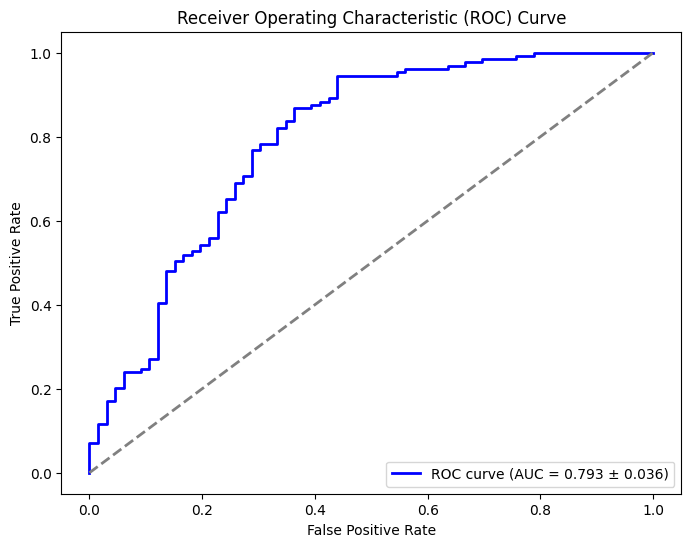

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_data['class'], eos30f3_hERG_predictions['activity'])
auc = roc_auc_score(test_data['class'], eos30f3_hERG_predictions['activity'])

n_bootstraps = 1000
auc_values = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    indices = np.random.choice(len(test_data['class']), len(test_data['class']), replace=True)
    auc_values[i] = roc_auc_score(test_data['class'].iloc[indices], eos30f3_hERG_predictions['activity'].iloc[indices])


auc_std_error = np.std(auc_values)

print(f"AUC = {auc:.3f} ± {auc_std_error:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f} ± {auc_std_error:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('../figures/seos30f3_AUC.png')
plt.show()


***Calculating the AUC score and plotting the ROC curve for DMPNN-hERG model***

AUC = 0.793 ± 0.038


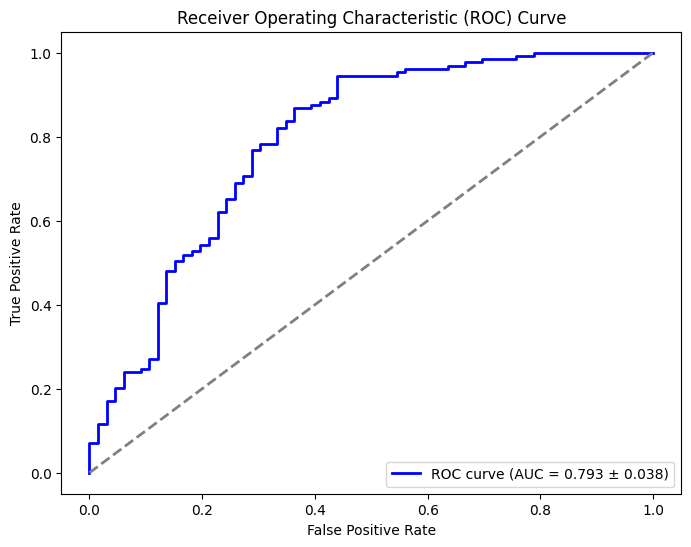

In [8]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_data['class'], DPMN_preds['class'])
auc = roc_auc_score(test_data['class'], DPMN_preds['class'])

n_bootstraps = 1000
auc_values = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    indices = np.random.choice(len(test_data['class']), len(test_data['class']), replace=True)
    auc_values[i] = roc_auc_score(test_data['class'].iloc[indices], DPMN_preds['class'].iloc[indices])


auc_std_error = np.std(auc_values)


print(f"AUC = {auc:.3f} ± {auc_std_error:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f} ± {auc_std_error:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('../figures/DPMN_AUC.png')
plt.show()

***We can observe from above that the Model implementation in EMH produce the exact same value as the Model from the Publications***


# Comparison on other Classsification metrics


In [9]:
import math
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score

threshold = 0.5


metrics = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Balanced Accuracy", "MCC", "Cohen's Kappa"]

table = PrettyTable()
table.field_names = metrics

models = [
    {"name": "eos30f3_hERG", "y_pred": eos30f3_hERG_predictions['activity']},
    {"name": "DPMN", "y_pred": DPMN_preds['class']}
]

for model in models:
    table.add_row([model["name"], "", "", "", "", "", "", "", ""])

    y_pred = model["y_pred"]
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_true = test_data['class']

    # Calculating the evaluation metrics
    accuracy = round(accuracy_score(y_true, y_pred_binary), 4)
    precision = round(precision_score(y_true, y_pred_binary), 4)
    recall = round(recall_score(y_true, y_pred_binary), 4)
    f1 = round(f1_score(y_true, y_pred_binary), 4)
    roc_auc = round(roc_auc_score(y_true, y_pred), 4)
    balanced_accuracy = round(balanced_accuracy_score(y_true, y_pred_binary), 4)
    mcc = round(matthews_corrcoef(y_true, y_pred_binary), 4)
    cohen_kappa = round(cohen_kappa_score(y_true, y_pred_binary), 4)

   
    table.add_row(["", accuracy, precision, recall, f1, roc_auc, balanced_accuracy, mcc, cohen_kappa])


print(table)


+--------------+----------+-----------+--------+----------+---------+-------------------+--------+---------------+
|    Model     | Accuracy | Precision | Recall | F1 Score | ROC AUC | Balanced Accuracy |  MCC   | Cohen's Kappa |
+--------------+----------+-----------+--------+----------+---------+-------------------+--------+---------------+
| eos30f3_hERG |          |           |        |          |         |                   |        |               |
|              |  0.7897  |   0.8014  | 0.907  |  0.8509  |  0.7929 |       0.7338      | 0.5101 |     0.499     |
|     DPMN     |          |           |        |          |         |                   |        |               |
|              |  0.7897  |   0.8014  | 0.907  |  0.8509  |  0.7929 |       0.7338      | 0.5101 |     0.499     |
+--------------+----------+-----------+--------+----------+---------+-------------------+--------+---------------+


 ***As can be observed from above both model produce the exact same value across all classification metrics using the same test Datasets.***
 
***This consistency indicates the reproducibility of our eos30f3 model, though it shoud be noted that the Model that was implemented on Ersilia was the one that was trained with 393 compounds and not the one trained with the cai datasets of 7889 compounds.***